In [7]:
import scanpy as sc
import numpy as np
import pandas as pd
import time
import scvi
import anndata
import pandas as pd
from scipy.io import mmread
from scipy.sparse import csr_matrix
import umap
import matplotlib.pyplot as plt
import os
import tempfile
import seaborn as sns
import torch
import scgen
import scib
import louvain

In [9]:
import warnings

sc.set_figure_params(figsize=(6, 6), frameon=False)
sns.set_theme()
torch.set_float32_matmul_precision("high")
save_dir = tempfile.TemporaryDirectory()

%config InlineBackend.print_figure_kwargs={"facecolor": "w"}
%config InlineBackend.figure_format="retina"

# Suppress specific ImportWarning
warnings.filterwarnings("ignore", category=ImportWarning, message=".*AltairImportHook.find_spec() not found; falling back to find_module.*")

/opt/anaconda3/lib/python3.12/site-packages/scanpy/_settings.py:488: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  IPython.display.set_matplotlib_formats(*ipython_format)
/opt/anaconda3/lib/python3.12/tempfile.py:936: ResourceWarning: Implicitly cleaning up <TemporaryDirectory '/var/folders/6f/wd7m9z0d6wg__mwtlh6w4f7h0000gn/T/tmp0gvasdpn'>
  _warnings.warn(warn_message, ResourceWarning)


In [11]:
adata = anndata.read_h5ad("./human_immune.h5ad")
adata

/opt/anaconda3/lib/python3.12/site-packages/anndata/_io/specs/registry.py:256: OldFormatWarning: Element '/layers' was written without encoding metadata.
  return self.callback(read_func, elem.name, elem, iospec=iospec)
/opt/anaconda3/lib/python3.12/site-packages/anndata/_io/specs/registry.py:256: OldFormatWarning: Element '/layers/counts' was written without encoding metadata.
  return self.callback(read_func, elem.name, elem, iospec=iospec)
/opt/anaconda3/lib/python3.12/site-packages/anndata/_io/utils.py:207: OldFormatWarning: Element '/obs/__categories/batch' was written without encoding metadata.
  return func(*args, **kwargs)
/opt/anaconda3/lib/python3.12/site-packages/anndata/_io/utils.py:207: OldFormatWarning: Element '/obs/batch' was written without encoding metadata.
  return func(*args, **kwargs)
/opt/anaconda3/lib/python3.12/site-packages/anndata/_io/utils.py:207: OldFormatWarning: Element '/obs/__categories/chemistry' was written without encoding metadata.
  return func(*ar

AnnData object with n_obs × n_vars = 33506 × 12303
    obs: 'batch', 'chemistry', 'data_type', 'dpt_pseudotime', 'final_annotation', 'mt_frac', 'n_counts', 'n_genes', 'sample_ID', 'size_factors', 'species', 'study', 'tissue'
    layers: 'counts'

In [13]:
## Setting: randomly missing labels
np.random.seed(666)
total_cells = adata.n_obs

# Calculate the number of cells to label
num_labeled = int(0.5 * total_cells)

# Initialize all labels with NaN
semi_labels = pd.Series(np.nan, index=adata.obs.index)

# Randomly select 50% of the indices without replacement
indices = np.random.choice(adata.obs.index, size=num_labeled, replace=False)

# Assign the corresponding 'cell_type' labels to these selected indices
semi_labels.loc[indices] = adata.obs.loc[indices, 'final_annotation']

# Now 'semi_labels' contains 50% known labels and 50% NaN
adata.obs['hard_label'] = semi_labels
#when the method requires fillna, ssSTACAS do not need this filling, but scANVI requires)
adata.obs['hard_label'].fillna("Unknown", inplace=True)
adata.obs['hard_label'] = adata.obs['hard_label'].astype('category')

/var/folders/6f/wd7m9z0d6wg__mwtlh6w4f7h0000gn/T/ipykernel_13860/2668954616.py:15: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '['CD20+ B cells', 'Monocyte-derived dendritic cells', 'CD20+ B cells', 'CD20+ B cells', 'NKT cells', ..., 'CD14+ Monocytes', 'Erythrocytes', 'CD14+ Monocytes', 'CD14+ Monocytes', 'CD4+ T cells']
Length: 16753
Categories (16, object): ['CD4+ T cells', 'CD8+ T cells', 'CD10+ B cells', 'CD14+ Monocytes', ..., 'NK cells', 'NKT cells', 'Plasma cells', 'Plasmacytoid dendritic cells']' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  semi_labels.loc[indices] = adata.obs.loc[indices, 'final_annotation']
/var/folders/6f/wd7m9z0d6wg__mwtlh6w4f7h0000gn/T/ipykernel_13860/2668954616.py:20: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pand

In [15]:
# Initialize the dictionary to store embeddings
embeddings_dict = {}

In [17]:
# preprocessing
adata.raw = adata
adata.layers["counts"] = adata.X.copy()
sc.pp.filter_cells(adata, min_genes=300)
sc.pp.filter_genes(adata, min_cells=5)
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, n_top_genes=2000, batch_key='batch')
adata = adata[:, adata.var['highly_variable']]

In [18]:
# Save the new_labels column to a CSV file
adata.obs[['hard_label']].to_csv('./hard_label_human_immune_50.csv', index=True)

# scANVI

In [8]:
# scVI
adata = adata.copy()
scvi.model.SCVI.setup_anndata(adata, layer="counts", batch_key="batch")
vae = scvi.model.SCVI(adata, n_layers=2, n_latent=50, gene_likelihood="nb")
vae.train()
adata.obsm["X_scVI"] = vae.get_latent_representation()
sc.pp.neighbors(adata, use_rep="X_scVI")
sc.tl.umap(adata, min_dist=0.5)

/opt/anaconda3/lib/python3.12/site-packages/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/opt/anaconda3/lib/python3.12/site-packages/lightning/pytorch/trainer/setup.py:187: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/opt/anaconda3/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Epoch 239/239: 100%|█| 239/239 [10:28<00:00,  2.76s/it, v_num=1, train_loss_step

`Trainer.fit` stopped: `max_epochs=239` reached.


Epoch 239/239: 100%|█| 239/239 [10:28<00:00,  2.63s/it, v_num=1, train_loss_step


In [22]:
# Set up the AnnData object
adata = adata.copy()
scvi.model.SCVI.setup_anndata(adata, layer="counts", batch_key="batch")

# Load the trained model
model_path = "./model_scVI"
vae = scvi.model.SCVI.load(model_path, adata=adata)

# Now you can use the loaded model for further analysis or inference
adata.obsm["X_scVI"] = vae.get_latent_representation()
sc.pp.neighbors(adata, use_rep="X_scVI")
sc.tl.umap(adata, min_dist=0.5)

/opt/anaconda3/lib/python3.12/site-packages/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)


INFO     File ./model_scVI/model.pt already downloaded                                                             


/opt/anaconda3/lib/python3.12/site-packages/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)


In [23]:
# Save embeddings
adata.obsm["X_scVI"] = adata.obsm["X_scVI"]

# Collect embeddings
embeddings_dict["X_scVI"] = adata.obsm["X_scVI"]

/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(


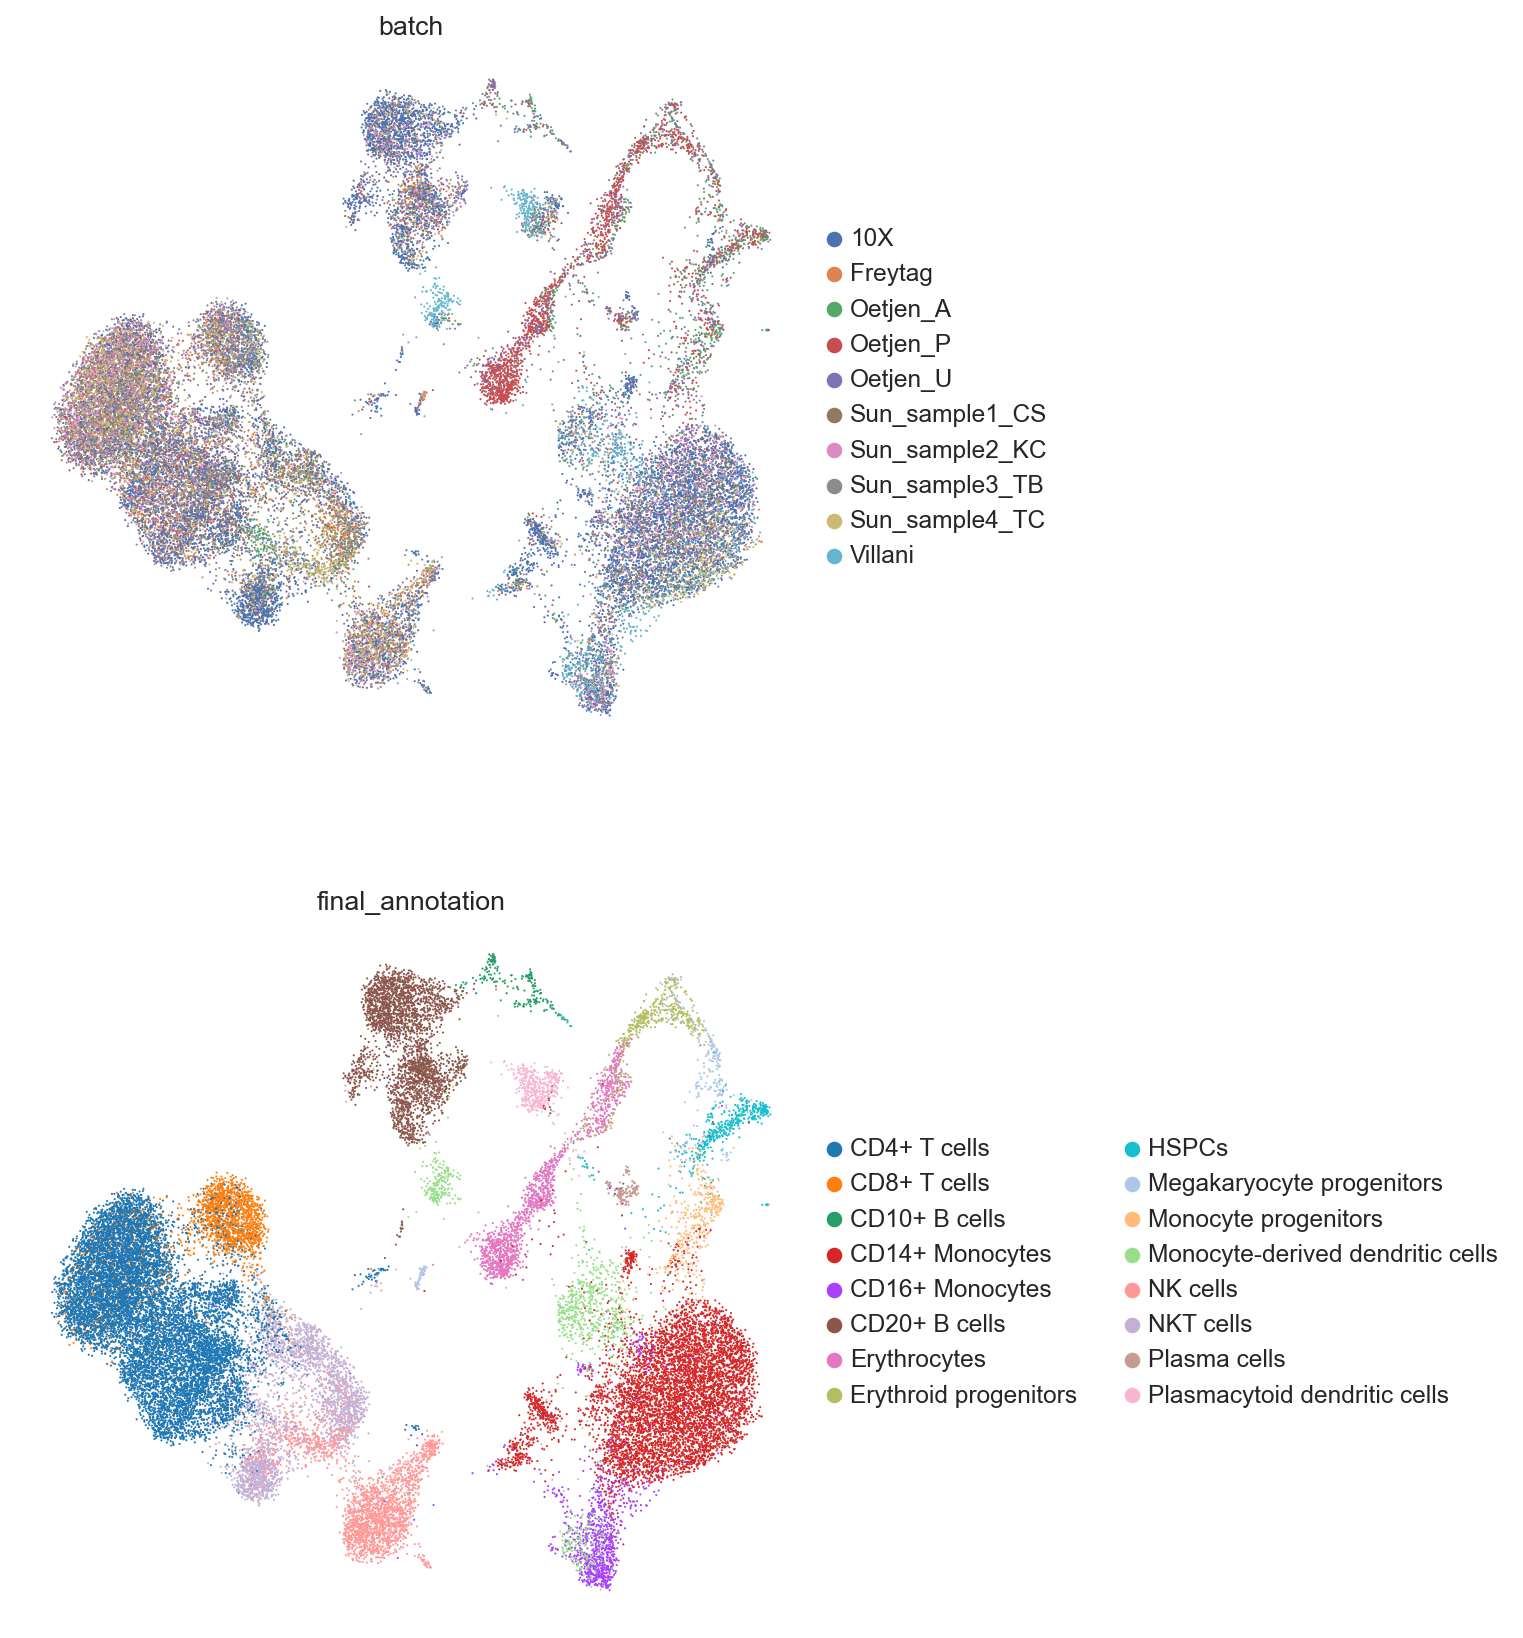

In [24]:
sc.pl.umap(adata, color=["batch", "final_annotation"], frameon=False, ncols=1)

scANVI should be initialized from a scVI model pre-trained on the same exact data.

In [26]:
scanvi_model = scvi.model.SCANVI.from_scvi_model(
    vae,
    adata=adata,
    labels_key="hard_label",
    unlabeled_category="Unknown",
)

/opt/anaconda3/lib/python3.12/site-packages/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)


In [27]:
scanvi_model.train(max_epochs=20, n_samples_per_label=100)

INFO     Training for 20 epochs.                                                                                   


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/opt/anaconda3/lib/python3.12/site-packages/lightning/pytorch/trainer/setup.py:187: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/opt/anaconda3/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Epoch 20/20: 100%|█| 20/20 [04:18<00:00, 13.16s/it, v_num=1, train_loss_step=525

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 20/20: 100%|█| 20/20 [04:18<00:00, 12.90s/it, v_num=1, train_loss_step=525


In [28]:
SCANVI_LATENT_KEY = "X_scANVI"
SCANVI_PREDICTIONS_KEY = "C_scANVI"

adata.obsm[SCANVI_LATENT_KEY] = scanvi_model.get_latent_representation(adata)
adata.obs[SCANVI_PREDICTIONS_KEY] = scanvi_model.predict(adata)

In [29]:
# Save the embeddings
# Collect scANVI embeddings and predictions in the dictionary
embeddings_dict[SCANVI_LATENT_KEY] = adata.obsm[SCANVI_LATENT_KEY]
embeddings_dict[SCANVI_PREDICTIONS_KEY] = adata.obs[SCANVI_PREDICTIONS_KEY]

In [30]:
sc.pp.neighbors(adata, use_rep=SCANVI_LATENT_KEY)
sc.tl.umap(adata)

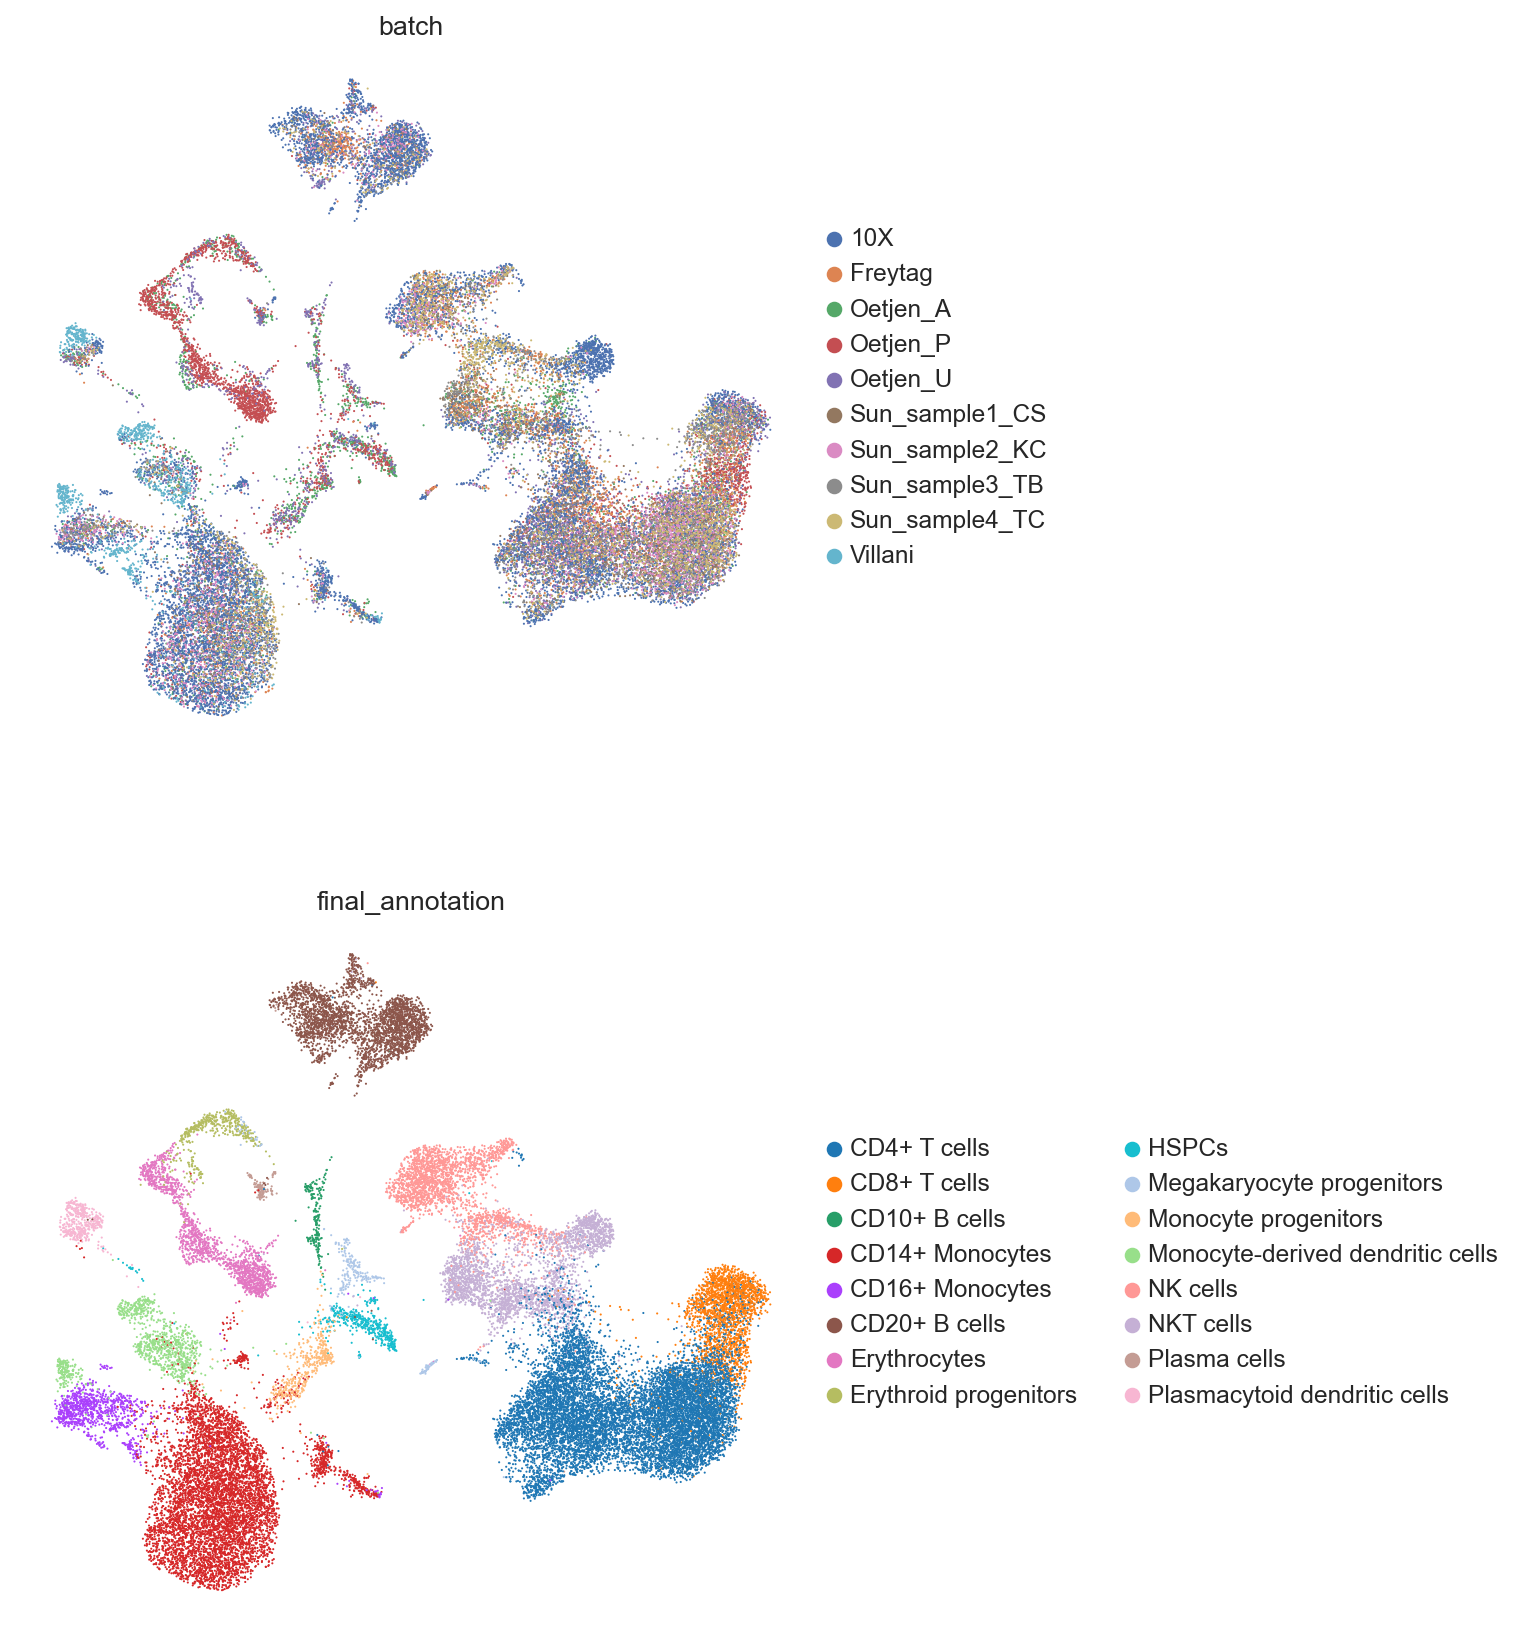

In [31]:
sc.pl.umap(adata, color=["batch", "final_annotation"], frameon=False, ncols=1)

# scGEN

We need two observation labels "batch" and "final_annotation" for our batch_removal procedure. There exist a "batch" obs but no "final_annotation", so we add it as a .obs of adata (but we have cell_type in this datasets)

In [34]:
train = adata.copy()

### Preprocessing Data

In [36]:
scgen.SCGEN.setup_anndata(train, batch_key="batch", labels_key="hard_label")

## Creating and Training the model¶

In [38]:
model = scgen.SCGEN(train)

model.train(
    max_epochs=100,
    batch_size=32,
    early_stopping=True,
    early_stopping_patience=25,
)
# model.save("../saved_models/model_batch_removal.pt", overwrite=True)

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/opt/anaconda3/lib/python3.12/site-packages/lightning/pytorch/trainer/setup.py:187: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/opt/anaconda3/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/opt/anaconda3/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Epoch 26/100:  26%|▎| 26/100 [08:54<25:19, 20.54s/it, v_num=1, train_loss_step=1
Monitored metric elbo_validation did not improve in the last 25 records. Best score: 1093.611. Signaling Trainer to stop.


## Batch-Removal

In [40]:
corrected_adata = model.batch_removal()
corrected_adata

/opt/anaconda3/lib/python3.12/site-packages/scgen/_scgen.py:268: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  all_shared_ann = AnnData.concatenate(


INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


AnnData object with n_obs × n_vars = 33506 × 2000
    obs: 'batch', 'chemistry', 'data_type', 'dpt_pseudotime', 'final_annotation', 'mt_frac', 'n_counts', 'n_genes', 'sample_ID', 'size_factors', 'species', 'study', 'tissue', 'hard_label', '_scvi_batch', '_scvi_labels', 'C_scANVI'
    uns: '_scvi_uuid', '_scvi_manager_uuid'
    obsm: 'latent', 'corrected_latent'

In [41]:
# Save embeddings
corrected_adata.obsm["X_scgen"] = corrected_adata.obsm["latent"]

# Collect embeddings
embeddings_dict["X_scgen"] = corrected_adata.obsm["X_scgen"]

### Visualization of the corrected gene expression data¶

In [43]:
sc.pp.neighbors(corrected_adata)
sc.tl.umap(corrected_adata)

/opt/anaconda3/lib/python3.12/site-packages/scanpy/tools/_utils.py:41: UserWarning: You’re trying to run this on 2000 dimensions of `.X`, if you really want this, set `use_rep='X'`.
         Falling back to preprocessing with `sc.pp.pca` and default params.
  warnings.warn(


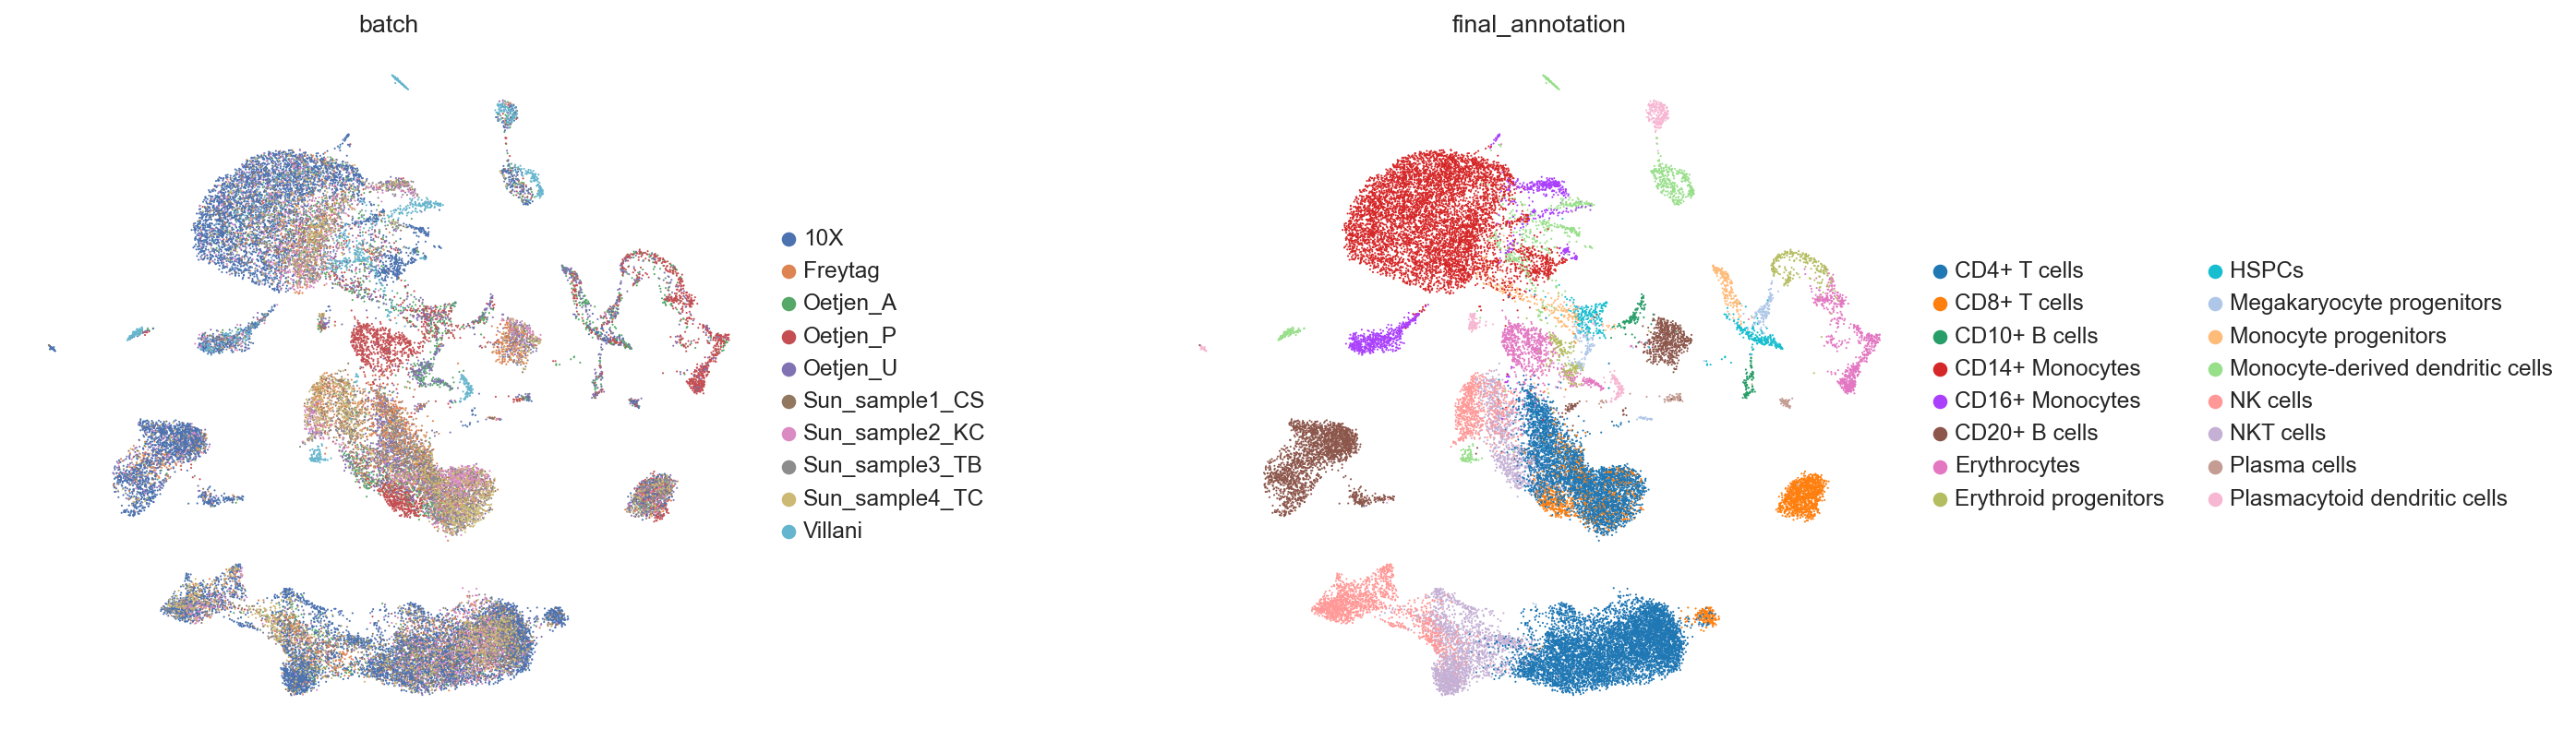

In [63]:
sc.pl.umap(corrected_adata, color=['batch', 'final_annotation'], wspace=0.4, frameon=False)

# STACAS

Semi-supervised integration results

In [69]:
pca_embeddings = pd.read_csv('./human_immune_stacas_embeddings_randomly_missing_labels_50.csv', index_col=0)
adata.obsm['X_stacas'] = pca_embeddings.values
sc.pp.neighbors(adata, use_rep="X_stacas")
sc.tl.umap(adata, min_dist=0.5)

In [74]:
# Collect embeddings
embeddings_dict["X_stacas"] = adata.obsm['X_stacas']

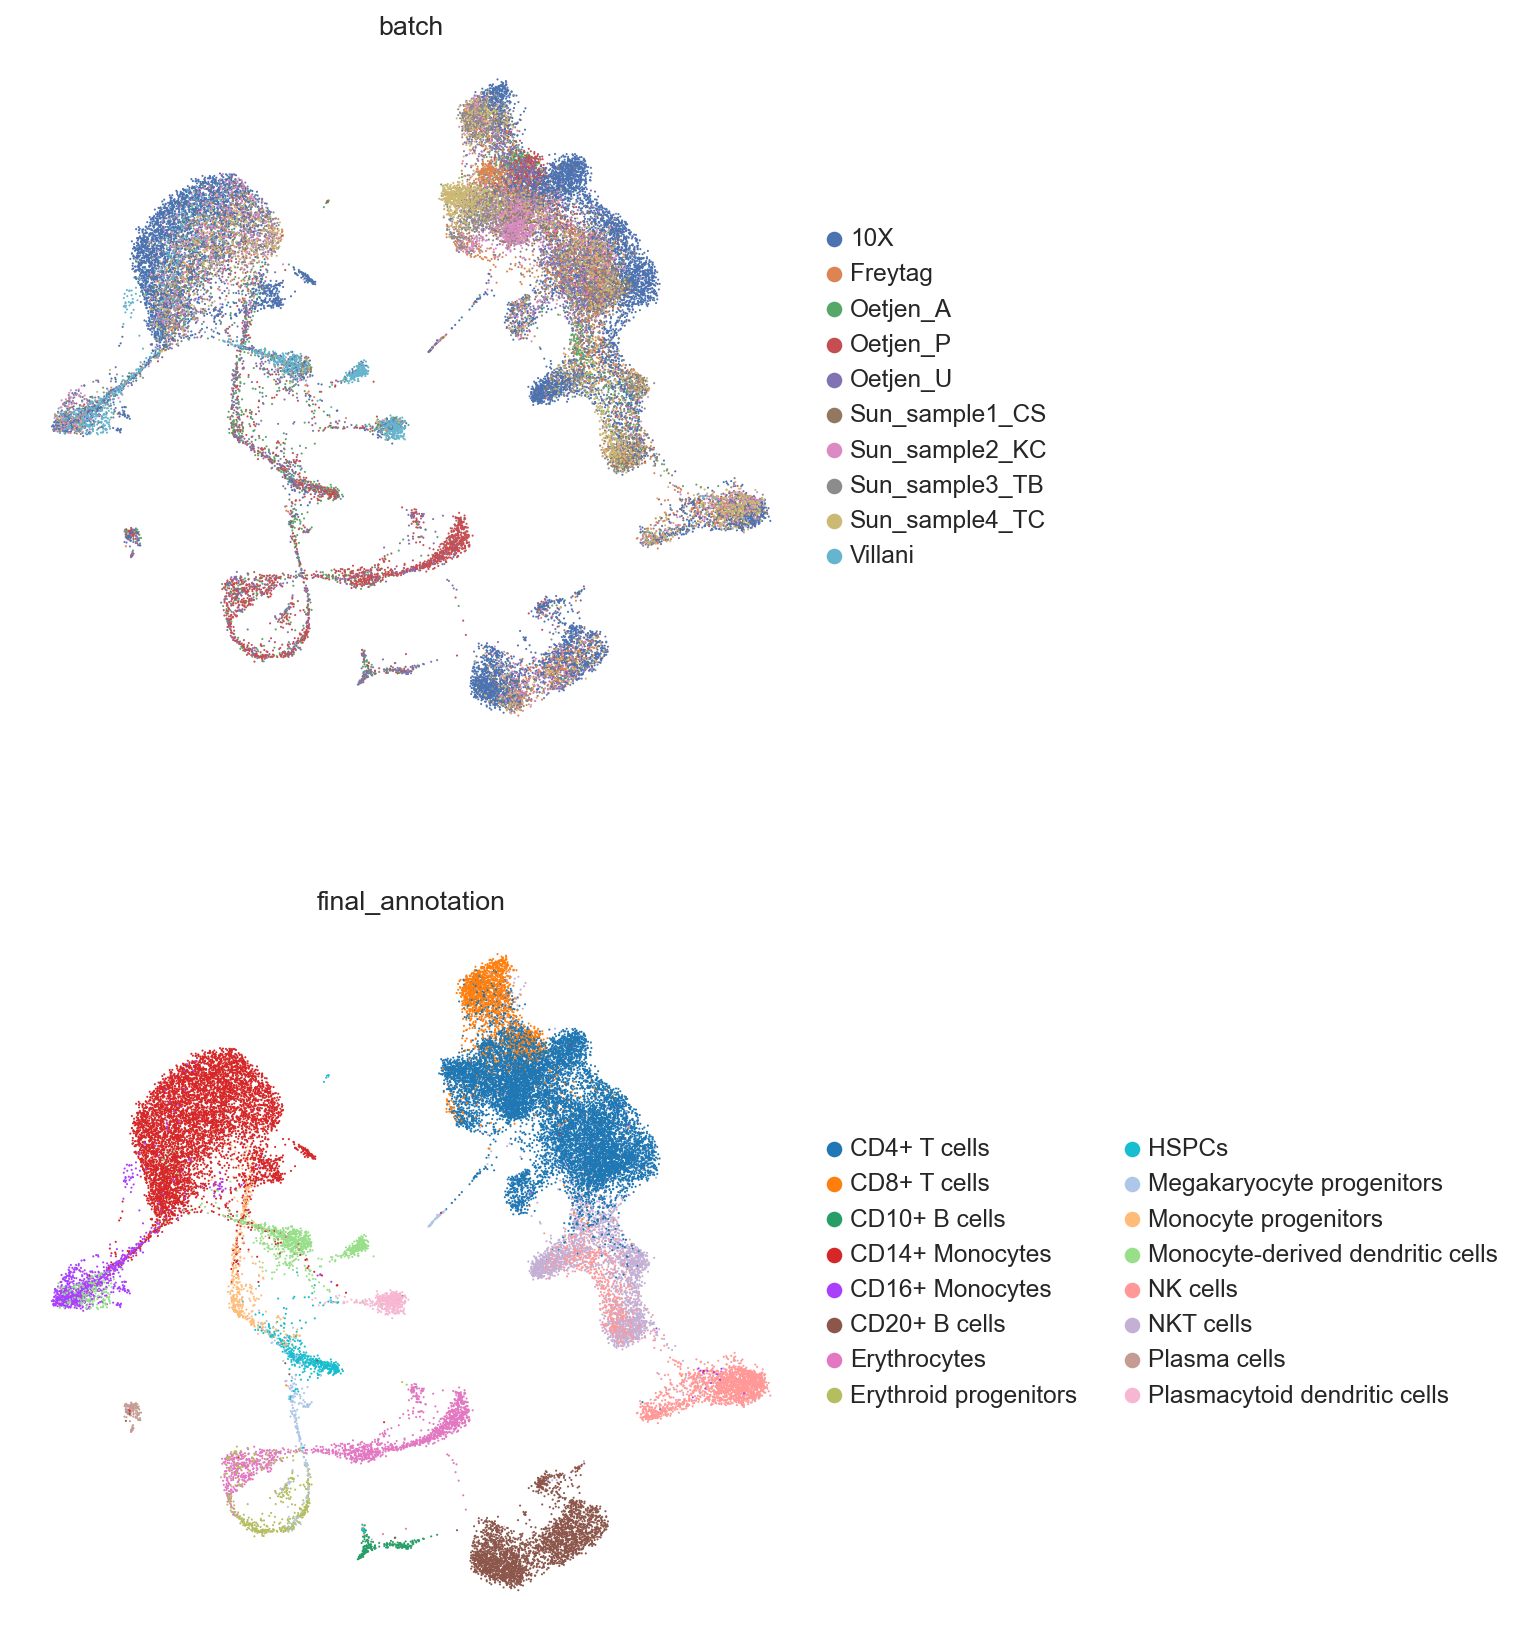

In [76]:
sc.pl.umap(adata, color=["batch", "final_annotation"], frameon=False, ncols=1)

In [78]:
# save all the embeddings
# Concatenate embeddings and save to CSV
combined_embeddings = pd.concat(
    {key: pd.DataFrame(value, index=adata.obs_names) for key, value in embeddings_dict.items()},
    axis=1
)
combined_embeddings.to_csv("./randomly_missing_human_immune_50.csv")


## Metric Evaluation

In [80]:
# Step 1: Read the CSV file into a DataFrame
combined_embeddings = pd.read_csv("./randomly_missing_human_immune_50.csv", index_col=0)

# Step 2: Ensure indices match
combined_embeddings = combined_embeddings.loc[adata.obs_names]

# Step 3: Split the DataFrame into separate DataFrames for each embedding
embedding_keys = ["X_scANVI", "X_scgen", "X_stacas"]
embeddings_dict = {key: combined_embeddings.filter(like=key) for key in embedding_keys}

# Step 4: Assign the embeddings back to adata.obsm
for key, df in embeddings_dict.items():
    adata.obsm[key] = df.values

# Now `adata.obsm` contains the loaded embeddings

In [81]:
sc.pp.neighbors(adata, use_rep="X_scANVI")
scib.me.cluster_optimal_resolution(adata, cluster_key="cluster", label_key="final_annotation")
df1_1 = scib.me.metrics(adata, adata_int=adata, ari_=True, nmi_= True, isolated_labels_=True, isolated_labels_f1_=True, silhouette_=True, graph_conn_=True, isolated_labels_asw_=True,  batch_key='batch', label_key = 'final_annotation', embed = 'X_scANVI')

/opt/anaconda3/lib/python3.12/site-packages/scib/metrics/clustering.py:101: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  cluster_function(adata, resolution=res, key_added=cluster_key, **kwargs)


resolution: 0.1, nmi: 0.8216501895387709
resolution: 0.2, nmi: 0.8057306616461307
resolution: 0.3, nmi: 0.8109638053792341
resolution: 0.4, nmi: 0.8128335552639054
resolution: 0.5, nmi: 0.8126259172812589
resolution: 0.6, nmi: 0.8096630043258138
resolution: 0.7, nmi: 0.8067811659164424
resolution: 0.8, nmi: 0.7729412351700886
resolution: 0.9, nmi: 0.7786733999543298
resolution: 1.0, nmi: 0.7781488689487279
resolution: 1.1, nmi: 0.7689465983233151
resolution: 1.2, nmi: 0.7370958606690814
resolution: 1.3, nmi: 0.7351322643901138
resolution: 1.4, nmi: 0.7208698143573413
resolution: 1.5, nmi: 0.7207679876067253
resolution: 1.6, nmi: 0.7218398553385388
resolution: 1.7, nmi: 0.7166721017340384
resolution: 1.8, nmi: 0.710949325767023
resolution: 1.9, nmi: 0.7063948968357376
resolution: 2.0, nmi: 0.7040961988953692
optimised clustering against final_annotation
optimal cluster resolution: 0.1
optimal score: 0.8216501895387709


/opt/anaconda3/lib/python3.12/site-packages/scib/metrics/metrics.py:293: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  res_max, nmi_max, nmi_all = opt_louvain(


NMI...
ARI...
Silhouette score...
Isolated labels F1...


/opt/anaconda3/lib/python3.12/site-packages/scib/metrics/isolated_labels.py:272: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  batch_per_lab = tmp.groupby(label_key).agg({batch_key: "count"})


Compute neighbors on rep X_scANVI
Compute neighbors on rep X_scANVI
Compute neighbors on rep X_scANVI
Compute neighbors on rep X_scANVI
Isolated labels ASW...


/opt/anaconda3/lib/python3.12/site-packages/scib/metrics/isolated_labels.py:272: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  batch_per_lab = tmp.groupby(label_key).agg({batch_key: "count"})


Graph connectivity...


/opt/anaconda3/lib/python3.12/site-packages/scib/metrics/graph_connectivity.py:56: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  tab = pd.value_counts(labels)
/opt/anaconda3/lib/python3.12/site-packages/scib/metrics/graph_connectivity.py:56: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  tab = pd.value_counts(labels)
/opt/anaconda3/lib/python3.12/site-packages/scib/metrics/graph_connectivity.py:56: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  tab = pd.value_counts(labels)
/opt/anaconda3/lib/python3.12/site-packages/scib/metrics/graph_connectivity.py:56: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  tab = pd.value_counts(labels)
/opt/ana

In [82]:
sc.pp.neighbors(adata, use_rep="X_scgen")
scib.me.cluster_optimal_resolution(adata, cluster_key="cluster", label_key="final_annotation")
df2_1 = scib.me.metrics(adata, adata_int=adata, ari_=True, nmi_= True, isolated_labels_=True, isolated_labels_f1_=True, silhouette_=True, graph_conn_=True, isolated_labels_asw_=True,  batch_key='batch', label_key = 'final_annotation', embed = 'X_scgen')

resolution: 0.1, nmi: 0.6963668887090751
resolution: 0.2, nmi: 0.6819835196812893
resolution: 0.3, nmi: 0.7411837945722186
resolution: 0.4, nmi: 0.7642675940839068
resolution: 0.5, nmi: 0.7501978487870161
resolution: 0.6, nmi: 0.7439186871783681
resolution: 0.7, nmi: 0.7396723793214927
resolution: 0.8, nmi: 0.7187266568298877
resolution: 0.9, nmi: 0.7239020714715667
resolution: 1.0, nmi: 0.7241732266827918
resolution: 1.1, nmi: 0.7195148459357625
resolution: 1.2, nmi: 0.7208644855173417
resolution: 1.3, nmi: 0.7047325403050926
resolution: 1.4, nmi: 0.6937099561733203
resolution: 1.5, nmi: 0.6889375957962042
resolution: 1.6, nmi: 0.6952870519407002
resolution: 1.7, nmi: 0.6906515902178844
resolution: 1.8, nmi: 0.6914459621599098
resolution: 1.9, nmi: 0.6909187752772777
resolution: 2.0, nmi: 0.6901902381480525
optimised clustering against final_annotation
optimal cluster resolution: 0.4
optimal score: 0.7642675940839068


/opt/anaconda3/lib/python3.12/site-packages/scib/metrics/metrics.py:293: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  res_max, nmi_max, nmi_all = opt_louvain(


NMI...
ARI...
Silhouette score...
Isolated labels F1...
Compute neighbors on rep X_scgen


/opt/anaconda3/lib/python3.12/site-packages/scib/metrics/isolated_labels.py:272: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  batch_per_lab = tmp.groupby(label_key).agg({batch_key: "count"})


Compute neighbors on rep X_scgen
Compute neighbors on rep X_scgen
Compute neighbors on rep X_scgen
Isolated labels ASW...


/opt/anaconda3/lib/python3.12/site-packages/scib/metrics/isolated_labels.py:272: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  batch_per_lab = tmp.groupby(label_key).agg({batch_key: "count"})


Graph connectivity...


/opt/anaconda3/lib/python3.12/site-packages/scib/metrics/graph_connectivity.py:56: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  tab = pd.value_counts(labels)
/opt/anaconda3/lib/python3.12/site-packages/scib/metrics/graph_connectivity.py:56: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  tab = pd.value_counts(labels)
/opt/anaconda3/lib/python3.12/site-packages/scib/metrics/graph_connectivity.py:56: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  tab = pd.value_counts(labels)
/opt/anaconda3/lib/python3.12/site-packages/scib/metrics/graph_connectivity.py:56: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  tab = pd.value_counts(labels)
/opt/ana

In [83]:
sc.pp.neighbors(adata, use_rep="X_stacas")
scib.me.cluster_optimal_resolution(adata, cluster_key="cluster", label_key="final_annotation")
df3_1 = scib.me.metrics(adata, adata_int=adata, ari_=True, nmi_= True, isolated_labels_=True, isolated_labels_f1_=True, silhouette_=True, graph_conn_=True, isolated_labels_asw_=True,  batch_key='batch', label_key = 'final_annotation', embed = 'X_stacas')

resolution: 0.1, nmi: 0.8304511276442289
resolution: 0.2, nmi: 0.8021370537236439
resolution: 0.3, nmi: 0.7948465870070152
resolution: 0.4, nmi: 0.795620749455244
resolution: 0.5, nmi: 0.7931386740812532
resolution: 0.6, nmi: 0.7803575036207624
resolution: 0.7, nmi: 0.7558635612069814
resolution: 0.8, nmi: 0.7469753757182448
resolution: 0.9, nmi: 0.7407254724361335
resolution: 1.0, nmi: 0.7406516963056127
resolution: 1.1, nmi: 0.7415820861161357
resolution: 1.2, nmi: 0.7306838672839862
resolution: 1.3, nmi: 0.7292787391327478
resolution: 1.4, nmi: 0.7223425489996721
resolution: 1.5, nmi: 0.7137742298952419
resolution: 1.6, nmi: 0.7013088129764888
resolution: 1.7, nmi: 0.6898668880128256
resolution: 1.8, nmi: 0.6912643631049039
resolution: 1.9, nmi: 0.690256894936973
resolution: 2.0, nmi: 0.6899331861360072
optimised clustering against final_annotation
optimal cluster resolution: 0.1
optimal score: 0.8304511276442289


/opt/anaconda3/lib/python3.12/site-packages/scib/metrics/metrics.py:293: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  res_max, nmi_max, nmi_all = opt_louvain(


NMI...
ARI...
Silhouette score...
Isolated labels F1...
Compute neighbors on rep X_stacas


/opt/anaconda3/lib/python3.12/site-packages/scib/metrics/isolated_labels.py:272: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  batch_per_lab = tmp.groupby(label_key).agg({batch_key: "count"})


Compute neighbors on rep X_stacas
Compute neighbors on rep X_stacas
Compute neighbors on rep X_stacas
Isolated labels ASW...


/opt/anaconda3/lib/python3.12/site-packages/scib/metrics/isolated_labels.py:272: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  batch_per_lab = tmp.groupby(label_key).agg({batch_key: "count"})


Graph connectivity...


/opt/anaconda3/lib/python3.12/site-packages/scib/metrics/graph_connectivity.py:56: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  tab = pd.value_counts(labels)
/opt/anaconda3/lib/python3.12/site-packages/scib/metrics/graph_connectivity.py:56: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  tab = pd.value_counts(labels)
/opt/anaconda3/lib/python3.12/site-packages/scib/metrics/graph_connectivity.py:56: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  tab = pd.value_counts(labels)
/opt/anaconda3/lib/python3.12/site-packages/scib/metrics/graph_connectivity.py:56: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  tab = pd.value_counts(labels)
/opt/ana

In [84]:
# Adding new columns to each dataframe
df1_1['scANVI'] = df1_1.iloc[:, 0]
df2_1['scGEN'] = df2_1.iloc[:, 0]
df3_1['STACAS'] = df3_1.iloc[:, 0]

# Selecting only the new columns to avoid duplicate data
df1_1 = df1_1[['scANVI']]
df2_1 = df2_1[['scGEN']]
df3_1 = df3_1[['STACAS']]

# Merging the dataframes along the columns
merged_df = pd.concat([df1_1, df2_1, df3_1], axis=1)

merged_df

scANVI     scGEN    STACAS
NMI_cluster/label          0.843028  0.762821  0.831188
ARI_cluster/label          0.855993  0.753175  0.824959
ASW_label                  0.634046  0.560302  0.597747
ASW_label/batch            0.875531  0.933312  0.899982
PCR_batch                       NaN       NaN       NaN
cell_cycle_conservation         NaN       NaN       NaN
isolated_label_F1          0.898648  0.580690  0.844694
isolated_label_silhouette  0.694827  0.584322  0.650638
graph_conn                 0.979447  0.932698  0.973292
kBET                            NaN       NaN       NaN
iLISI                           NaN       NaN       NaN
cLISI                           NaN       NaN       NaN
hvg_overlap                     NaN       NaN       NaN
trajectory                      NaN       NaN       NaN